In [1]:
#imports
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

In [2]:
#import dataset
#when importing the csv file utf-8 code error was occuring. Changed the encoding to ISO.
df = pd.read_csv('usa_hospital_beds-2.csv', na_filter=False, encoding='ISO-8859-1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6626 entries, 0 to 6625
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   X                                6626 non-null   object
 1   Y                                6626 non-null   object
 2   ID                               6626 non-null   int64 
 3   HOSPITAL_NAME                    6626 non-null   object
 4   HOSPITAL_TYPE                    6626 non-null   object
 5   ADDRESS                          6626 non-null   object
 6   CITY                             6626 non-null   object
 7   STATE                            6626 non-null   object
 8   ZIP_CODE                         6626 non-null   int64 
 9   COUNTY_NAME                      6626 non-null   object
 10  STATE_NAME                       6626 non-null   object
 11  NUM_LICENSED_BEDS                6626 non-null   object
 12  NUM_STAFFED_BEDS                 6

### 1. Identifying data types

Changes that should be made:
- ZIP_CODE -> Object
- X -> float
- Y -> float
- BED_UTILIZATION -> float

The below should be changed to ints however applying NaN to these is not possible. Using na() and filling with a number would be the approach however, these could impact these results as it is possible that 0 could be the value. NaNs are also easier to handle in pandas.
- NUM_LICENSED_BEDS -> float
- NUM_STAFFED_BEDS -> float
- AVG_VENTILATOR_USAGE -> float

In [3]:
#replace the empty strings and convert to the appropriate data type
#typecast to float
df['X'] =df['X'].replace('', np.nan).astype(float)
df['Y'] =df['Y'].replace('', np.nan).astype(float)
df['NUM_LICENSED_BEDS'] =df['NUM_LICENSED_BEDS'].replace('', np.nan).astype(float)
df['NUM_STAFFED_BEDS'] =df['NUM_STAFFED_BEDS'].replace('', np.nan).astype(float)
df['BED_UTILIZATION'] =df['BED_UTILIZATION'].replace('', np.nan).astype(float)
df['AVG_VENTILATOR_USAGE'] =df['AVG_VENTILATOR_USAGE'].replace('', np.nan).astype(float)

#typecast to object
df['ZIP_CODE'] =df['ZIP_CODE'].replace('', np.nan).astype(object)

In [4]:
df['NUM_LICENSED_BEDS'].describe()

count    6403.000000
mean      148.087303
std       182.684947
min         1.000000
25%        25.000000
50%        75.000000
75%       197.000000
max      2059.000000
Name: NUM_LICENSED_BEDS, dtype: float64

In [5]:
df['NUM_STAFFED_BEDS'].describe()

count    6328.000000
mean      127.668458
std       160.116186
min         1.000000
25%        25.000000
50%        65.000000
75%       166.000000
max      2753.000000
Name: NUM_STAFFED_BEDS, dtype: float64

In [6]:
df['NUM_LICENSED_BEDS'].isna().sum()

223

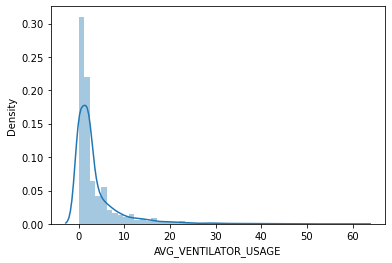

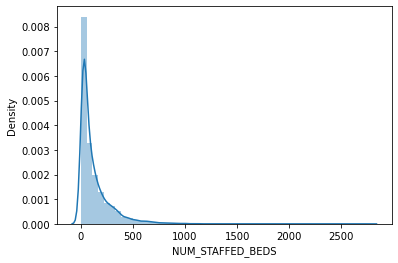

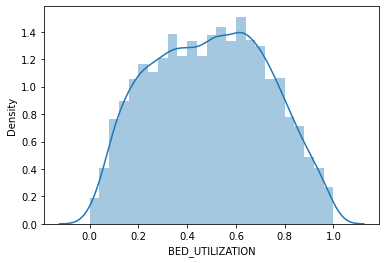

In [7]:
#distribution of AVG_VENTILATOR_USAGE
vent_dist = sns.distplot(df['AVG_VENTILATOR_USAGE'].dropna())
plt.show()

#distribution of NUM_STAFFED_BEDS
staffed_dist = sns.distplot(df['NUM_STAFFED_BEDS'].dropna())
plt.show()

#distribution of BED_UTILIZATION
staffed_dist = sns.distplot(df['BED_UTILIZATION'].dropna())
plt.show()

shows no erroneous data, can continue with clustering process

In [8]:
#take the three variables and drop the rest
df2 = df[['AVG_VENTILATOR_USAGE','NUM_STAFFED_BEDS','BED_UTILIZATION']]

#drop na values from df2
df2 = df2.dropna()

#convert df2 to matrix
X = df2.to_numpy()

#scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [9]:
#set random state
rs = 10

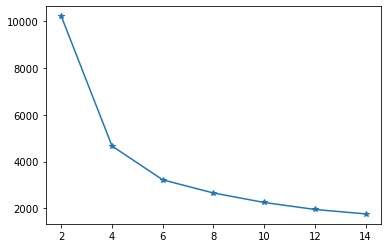

In [10]:
#Elbow method to choose clusters
# list to save the clusters and cost
clusters = []
inertia_vals = []

# this whole process should take a while
for k in range(2, 15, 2):
    #train clustering with the specified K
    model = KMeans(n_clusters=k, random_state=rs, n_jobs = 10)
    model.fit(X)
    
    #append model to cluster list
    clusters.append(model)
    inertia_vals.append(model.inertia_)

#plot the ineria vs k values
plt.plot(range(2,15,2), inertia_vals, marker='*')
plt.show()

In [11]:
#set random state and cluster
model = KMeans(n_clusters=4, random_state=rs)
model.fit(X)

# sum of intra-cluster distances
print("Sum of intra-cluster distance:", model.inertia_)

print("Centroid locations:")
for centroid in model.cluster_centers_:
    print(centroid)

Sum of intra-cluster distance: 4667.944358623808
Centroid locations:
[-0.39700012 -0.48078738 -0.90974337]
[3.56504077 3.20106921 1.04978514]
[-0.35603368 -0.27640117  0.85302232]
[0.86855478 1.02350431 0.53352117]


Cluster membership
0    2700
2    1935
3    1034
1     242
Name: Cluster_ID, dtype: int64


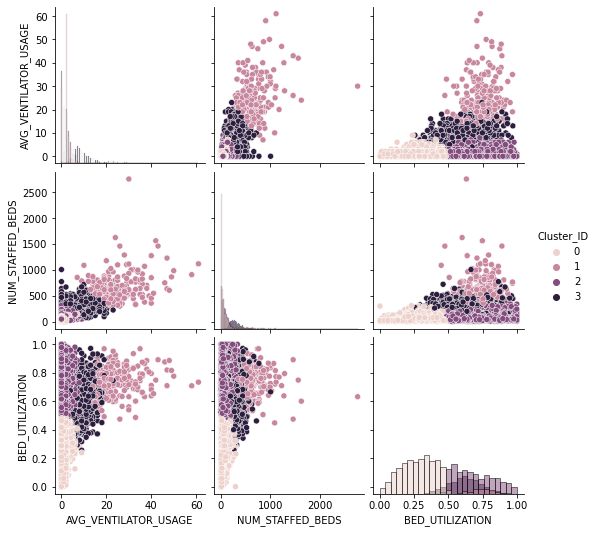

In [12]:
#visualising clusters is better than the printed text

model = KMeans(n_clusters=4, random_state=rs).fit(X)

#assign cluster ID to each record in X
#Ignore the warning - doesn't apply here
y = model.predict(X)
df2['Cluster_ID'] = y

#how many records are in each cluster
print("Cluster membership")
print(df2['Cluster_ID'].value_counts())

#pairplot the cluster distribution
cluster_g = sns.pairplot(df2, hue='Cluster_ID', diag_kind='hist')
plt.show()

average ventilation use is high when bed utilisation is high.
Average ventilation increases with more staffed beds.
Bed utilisation higher with more staffed beds, therefore places with more beds hold patients for longer. This could mean they have the capacity to provde greater healthcare. Looking at the data against patient outcomes could provide greater insights

2.1 - K-means algorithm has been used to perform clustering as all data types are numeric.
2.2 - Attributers are 'AVG_VENTILATOR_USAGE','NUM_STAFFED_BEDS','BED_UTILIZATION'
2.3 - By using the elbow method, it was determined that four clusters would provide the optimal clustering separation by decreasing intra-cluster space, and maximising inter-cluster space.
2.4 - Yes - Clustering is sensitive to inputs on different scales. Clustering uses proximity/distance measures - the most common being Euclidean. Euclidean favours larger scales therefore need to apply scaling before performing clustering.

3.1 - Visualised pairplot above
3.2 - Cluster 0 = Low ventiliation usage, low number of staffed beds, high bed utilisation;
    - Cluster 1 = Highest ventilation usage, highest staffed beds, high bed utilisation;
    - Cluster 2 = Low ventiliation usage, low number of staffed beds, lowest bed utilsation;
    - Cluster 3 = Moderate ventilaton usage, moderate number of staffed beds, moderate to high bed utilisation.

Distribution for cluster 0


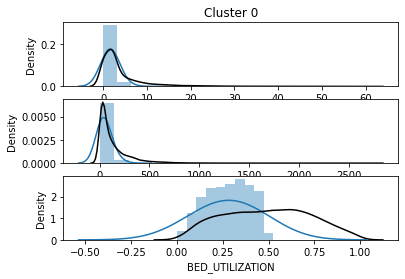

Distribution for cluster 1


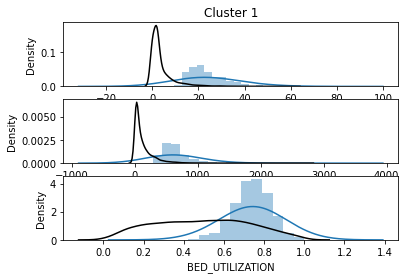

Distribution for cluster 2


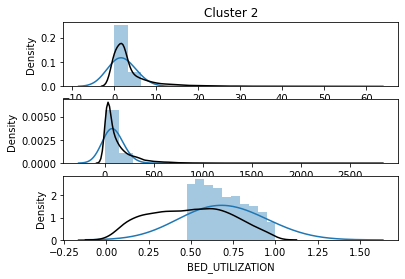

Distribution for cluster 3


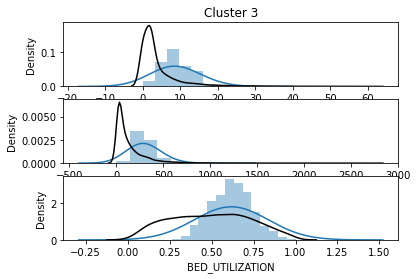

In [13]:
# prepare the column and bin size. Increase bin size to be more specific, but 20 is more than enough
cols = ['AVG_VENTILATOR_USAGE', 'NUM_STAFFED_BEDS', 'BED_UTILIZATION']
n_bins = 20


clusters_to_inspect = [0,1,2,3]

for cluster in clusters_to_inspect:
    print("Distribution for cluster {}".format(cluster))
    fig, ax = plt.subplots(nrows=3)
    ax[0].set_title("Cluster {}".format(cluster))

    for j, col in enumerate(cols):
        bins = np.linspace(min(df2[col]), max(df2[col]), 20)
        sns.distplot(df2[df2['Cluster_ID'] == cluster][col], bins=bins, ax=ax[j], norm_hist=True, kde_kws={'bw':1.5})
        sns.distplot(df2[col], bins=bins, ax=ax[j], hist=False, color="k")

    #plt.tight_layout()
    plt.show()

### K-Prototype for Question 4

In [14]:
#Variable selection
df3 = df[['AVG_VENTILATOR_USAGE','NUM_STAFFED_BEDS', 'BED_UTILIZATION', 'HOSPITAL_TYPE']]

In [15]:
print(df3['HOSPITAL_TYPE'].unique())

['VA Hospital' 'Short Term Acute Care Hospital' 'Critical Access Hospital'
 'Childrens Hospital' 'Long Term Acute Care Hospital'
 'Psychiatric Hospital' 'Rehabilitation Hospital'
 'Religious Non-Medical Health Care Institution'
 'Department of Defense Hospital']


In [16]:
print(df3['HOSPITAL_TYPE'].value_counts())

Short Term Acute Care Hospital                   3556
Critical Access Hospital                         1345
Psychiatric Hospital                              700
Long Term Acute Care Hospital                     360
Rehabilitation Hospital                           326
VA Hospital                                       160
Childrens Hospital                                125
Department of Defense Hospital                     38
Religious Non-Medical Health Care Institution      16
Name: HOSPITAL_TYPE, dtype: int64


In [17]:
#mapping the data to convert categorical to numerical
#mapping
hospital_map = {'VA Hospital': 1, 'Short Term Acute Care Hospital': 2, 'Critical Access Hospital': 3,
                'Childrens Hospital': 4, 'Long Term Acute Care Hospital': 5, 'Psychiatric Hospital': 6,
                'Rehabilitation Hospital': 7, 'Religious Non-Medical Health Care Institution': 8, 
                'Department of Defense Hospital': 9}

df3['HOSPITAL_TYPE'] = df3['HOSPITAL_TYPE'].map(hospital_map)

print(df3['HOSPITAL_TYPE'].value_counts())

#drop na values from df3
df3 = df3.dropna()

print(df3['HOSPITAL_TYPE'].value_counts())

#convert df to matrix
X = df3.to_numpy()

#scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

2    3556
3    1345
6     700
5     360
7     326
1     160
4     125
9      38
8      16
Name: HOSPITAL_TYPE, dtype: int64
2    3280
3    1343
6     567
5     347
7     294
4      65
8      15
Name: HOSPITAL_TYPE, dtype: int64


In [18]:
# Create a seperaate scaled dataframe for later plotting
to_cluster_scaled = pd.DataFrame(X, columns=df3.columns)

In [19]:
#set random state and cluster
#model = KMeans(n_clusters=4, random_state=rs)
#model.fit(X)

# sum of intra-cluster distances
#print("Sum of intra-cluster distance:", model.inertia_)

#print("Centroid locations:")
#for centroid in model.cluster_centers_:
    #print(centroid)

In [20]:
model = KPrototypes(n_clusters=4, random_state=rs, n_jobs=-1)
model.fit(X, categorical=[3])

df3['Cluster_ID'] = model.predict(X, categorical=[3])
to_cluster_scaled['Cluster_ID'] = model.predict(X, categorical=[3])

print("Cluster membership:")
print(df3.Cluster_ID.value_counts())

Cluster membership:
2    2847
0    1502
3    1279
1     283
Name: Cluster_ID, dtype: int64


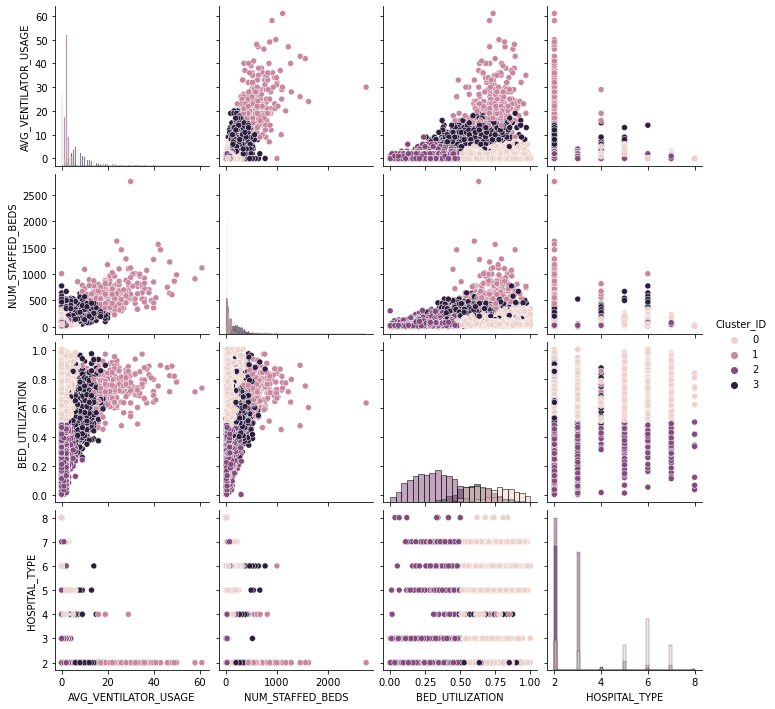

In [21]:
g = sns.pairplot(df3, hue='Cluster_ID', diag_kind='hist')

4.1 K-Prototypes was used as HOSPITAL_TYPE is categorical data.

4.2 Attributes were the same as the previous model, but with the addition of HOSPITAL_TYPE

    'AVG_VENTILATOR_USAGE','NUM_STAFFED_BEDS', 'BED_UTILIZATION', 'HOSPITAL_TYPE'
    
4.3 The following differences between the two models can be seen: 

    - From looking at the cluster membership we can see clearly that the clustering has changed due to the variation in count (hospitals in each cluster).
    - The cluster shapes have not changed much.
    - Cluster 0:
        - High ventilalation use
        - High number of staffed beds
        - High bed utilsation
        - Cluster 0 is mostly made of Short Term Acute Care hospitals
    - Cluster 1:
        - Low ventilalation use
        - Low number of staffed beds
        - High bed utilsation
    - Cluster 2:
        - Low to moderate ventilation use
        - Low to moderate number of staffed beds
        - Moderate to high bed utilisation
    - Cluster 3:
        - Low ventilalation use
        - Low number of staffed beds
        - Low to moderate bed utilsation

Distribution for cluster 0


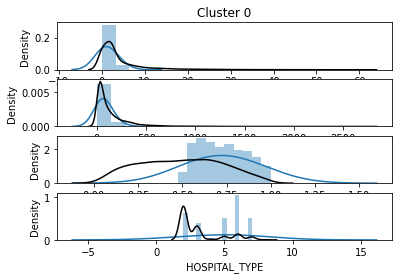

Distribution for cluster 1


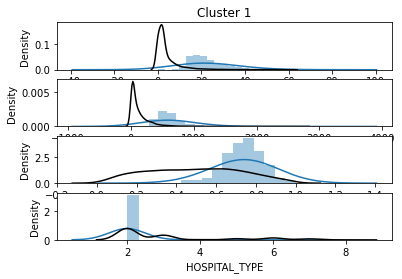

Distribution for cluster 2


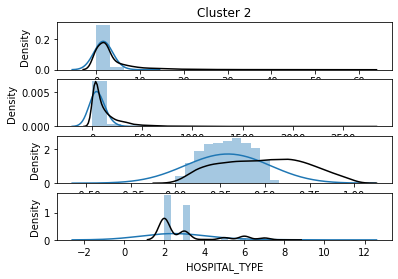

Distribution for cluster 3


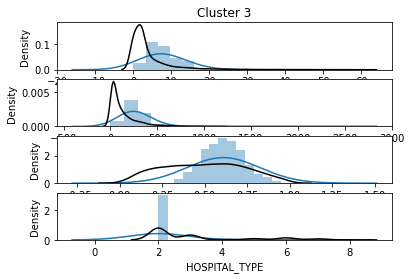

In [22]:
# prepare the column and bin size. Increase bin size to be more specific, but 20 is more than enough
cols = ['AVG_VENTILATOR_USAGE', 'NUM_STAFFED_BEDS', 'BED_UTILIZATION', 'HOSPITAL_TYPE']
n_bins = 20


clusters_to_inspect = [0,1,2,3]

for cluster in clusters_to_inspect:
    print("Distribution for cluster {}".format(cluster))
    fig, ax = plt.subplots(nrows=4)
    ax[0].set_title("Cluster {}".format(cluster))

    for j, col in enumerate(cols):
        bins = np.linspace(min(df3[col]), max(df3[col]), 20)
        sns.distplot(df3[df3['Cluster_ID'] == cluster][col], bins=bins, ax=ax[j], norm_hist=True, kde_kws={'bw':1.5})
        sns.distplot(df3[col], bins=bins, ax=ax[j], hist=False, color="k")

    #plt.tight_layout()
    plt.show()